In [21]:
import hashlib
import pandas as pd
import seaborn as sns
import pandahouse
import swifter
from scipy import stats


## Гипотеза


### К нам пришла команда ML с новыми алгортимами рекомандаций. Задача сделать пользователей 'счастливее'
1) Показываем пользователю посты, которые он лайкал  
2) Показываем пользователю посты, которые лайкали похожие на него пользователи

Для этого нам нужен показатель(метрика), который скажет нам, что посты стали интереснее. Для этого воспользумаемся метрикой CTR(клики в лайки)

CTR = (посты, которым поставили лайк)  / (все просмотры)

## Делим пользователей на группы

### Cистема сплитования

Требования к группам пользователей :
1) Мы хотим, чтобы разбиение было ***случайным***. Делается это для того, чтобы воздействие на них оказывалось *только* в рамках самого теста и *больше ничего*
2) Группа должна не меняться в течение эксперимента.  Если группа не будет сохраняться и человек будет скакать из одной группы в другую, то она увидит два алгоритма + она испортит п.1
3) Мы должны иметь возможность повторить ***то же самое разбиение*** (когда нам это понадобится). Тяжело будет считать эффект от эксперимента, если захотим запустить еще один

### Как побить пользователей на группы ###

Рассмотрим классический пример хеширования с солью :



In [10]:
def ab_split(user_id, salt = 'value', n_groups = 5):
    test_id = str(user_id) + '-' + str(salt)  # склеиваем в единую строку
    test_id_digest = hashlib.md5(test_id.encode('ascii')).hexdigest()  #перевод строки в число с Равномерным распределением
    test_id_final_int = int(test_id_digest, 16)
    return test_id_final_int % n_groups

In [14]:
id = 2
salt = 'exp_feed_1'
ab_split(id, salt)

4

Результат кода выше - детерминированный (всегда будет получаться то же разбиение)

In [20]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator'
}

q = """
SELECT distinct user_id
FROM {db}.feed_actions 
WHERE toDate(time) >= '2021-11-15' and toDate(time) <= '2021-11-21' 
"""
# Вытащили пользователей
users_df = pandahouse.read_clickhouse(q, connection=connection)

# Сделали группы
users_df['hash_group'] = users_df.user_id.swifter.apply(ab_split)

# Смотрим на число пользователей в каждой группе
users_df.groupby('hash_group').user_id.nunique().reset_index()

Pandas Apply:   0%|          | 0/50149 [00:00<?, ?it/s]

,hash_group,user_id
0,0,9950
1,1,10191
2,2,9871
3,3,10006
4,4,10131


### Проверка корректности работы системы сплитования

После того, как мы побили на группы пользователей, надо проверить, являются ли они статистически эквивалентными.  
Для этого нужно провести А/A тест. 
Проверить, что группы между собой не отличаются до тех пор, пока мы не выкатили на них новую функциональность

АА-тест проходил с 8 по 14 ноября 2021  
АБ-тест с нашими системами рекомендаций проходил с 15 по 21 ноября 2021

In [22]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2021-11-08' and '2021-11-14'
    and exp_group in (2,3)
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)

df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
2,8480,8480,8480,8480
3,8569,8569,8569,8569


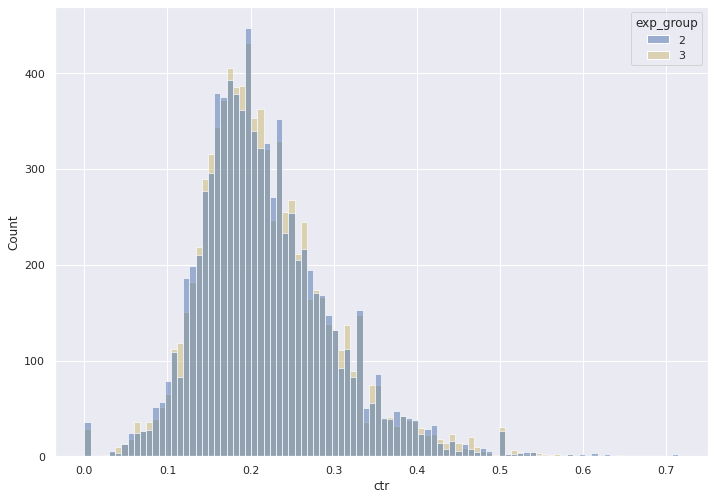

In [27]:

sns.set(rc={'figure.figsize':(11.7,8.27)})

groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['b', 'y'],
              alpha=0.5,
              kde=False)

Из распределния кажется, что группы статистически эквиваленты и проводить тест можно. Но это проверка на глаз, воспользуемся проверкой тестов